<a name="top"></a>
<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://docs.unidata.ucar.edu/images/logos/unidata_logo_vertical_150x150.png" alt="Unidata Logo" style="height: 98px;">
</div>

# Colorized Grid Data
**Python-AWIPS Tutorial Notebook**

<div style="clear:both"></div>
</div>

---

<div style="float:right; width:250 px"><img src="../images/grids_and_cartopy_preview.png" alt="Colorized RAP13 Conus image" style="height: 300px;"></div>


# Objectives

* Create a colorized plot for the continental US of model data (grib).
* Access the model data from an EDEX server and limit the data returned by using model specific parameters.
* Use both *pcolormesh* and *contourf* to create colorized plots, and compare the differences between the two.

---

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Define-Data-Request" data-toc-modified-id="Define-Data-Request-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Define Data Request</a></span></li><li><span><a href="#Limit-Results-Based-on-Time" data-toc-modified-id="Limit-Results-Based-on-Time-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Limit Results Based on Time</a></span></li><li><span><a href="#Function:-make_map()" data-toc-modified-id="Function:-make_map()-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Function: make_map()</a></span></li><li><span><a href="#Use-the-Grid-Data!" data-toc-modified-id="Use-the-Grid-Data!-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Use the Grid Data!</a></span><ul class="toc-item"><li><span><a href="#Plot-Using-pcolormesh" data-toc-modified-id="Plot-Using-pcolormesh-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Plot Using pcolormesh</a></span></li><li><span><a href="#Plot-Using-contourf" data-toc-modified-id="Plot-Using-contourf-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Plot Using contourf</a></span></li></ul></li><li><span><a href="#See-Also" data-toc-modified-id="See-Also-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>See Also</a></span><ul class="toc-item"><li><span><a href="#Related-Notebooks" data-toc-modified-id="Related-Notebooks-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Related Notebooks</a></span></li><li><span><a href="#Additional-Documentation" data-toc-modified-id="Additional-Documentation-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Additional Documentation</a></span></li></ul></li></ul></div>

## Imports

Start by importing both the python-awips specific library, as well as the libraries needed for plotting and manipulating the data

In [3]:
from awips.dataaccess import DataAccessLayer
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from scipy.constants import convert_temperature

<a href="#top">Top</a>

---

## Define Data Request

If you read through the [python-awips: How to Access Data](https://nbviewer.jupyter.org/github/Unidata/pyaos-ams-2021/blob/master/notebooks/dataAccess/python-awips-HowToAccessData.ipynb) training, you will know that we need to set an EDEX url to access our server, and then we create a data request.  In this example we use *grid* as the data type to define our request.
In addition to setting the data type, the location, parameters and levels are also set as **RAP13**, **T** (for temperature), and **2.0FHAG** (for Fixed Height Above Ground in meters), respectively.

In [4]:
DataAccessLayer.changeEDEXHost("edex-cloud.unidata.ucar.edu")
request = DataAccessLayer.newDataRequest()
request.setDatatype("grid")
request.setLocationNames("RAP13")
request.setParameters("T")
request.setLevels("2.0FHAG")

# Take a look at our request
print(request)

DefaultDataRequest(datatype=grid, identifiers={}, parameters=['T'], levels=[<dynamicserialize.dstypes.com.raytheon.uf.common.dataplugin.level.Level.Level object at 0x11127bfd0>], locationNames=['RAP13'], envelope=None)


<a href="#top">Top</a>

---

## Limit Results Based on Time

Models produce many different time variants during their runs, so let's limit the data to the most recent time and forecast run.

<div class="alert-info">
<b>Note:</b> You can play around with different times and forecast runs to see the differences.
</div>

In [5]:
cycles = DataAccessLayer.getAvailableTimes(request, True)
times = DataAccessLayer.getAvailableTimes(request)
fcstRun = DataAccessLayer.getForecastRun(cycles[-1], times)

# Get the most recent grid data
response = DataAccessLayer.getGridData(request, [fcstRun[0]])

print('Number of available times:', len(times))
print('Number of available forecast runs:', len(fcstRun))

Number of available times: 74
Number of available forecast runs: 8


<a href="#top">Top</a>

---

## Function: make_map()

In order to plot more than one image, it's easiest to define common logic in a function.  Here, a new function called **make_map** is defined.  This function uses the [matplotlib.pyplot package (plt)](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.html) to create a figure and axis.  The coastlines (continental boundaries) are added, along with lat/lon grids.

In [6]:
def make_map(bbox, projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(16, 9),
            subplot_kw=dict(projection=projection))
    ax.set_extent(bbox)
    ax.coastlines(resolution='50m')
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

<a href="#top">Top</a>

---

## Use the Grid Data!

Here we get our grid data object from our previous response, and then get the raw data array off that object.  We also get the latitude and longitude arrays, and create a bounding box that we'll use when creating our plots (by calling **make_map** defined above).  Finally, we'll convert our data from degrees Kelvin to Farenheit to make the plot more understandable.

In [7]:
grid = response[0]
data = grid.getRawData()
lons, lats = grid.getLatLonCoords()
bbox = [lons.min(), lons.max(), lats.min(), lats.max()]

# Convert temp from Kelvin to F
destUnit = 'F'
data = convert_temperature(data, 'K', destUnit)

### Plot Using pcolormesh

This example shows how to use [matplotlib.pyplot.pcolormesh](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.pcolormesh.html) to create a colorized plot. We use our **make_map** function to create a subplot and then we create a color scale (cs) and colorbar (cbar) with a label for our plot.

<div class="alert-info">
<b>Note:</b>  You may see a warning appear with a red background, this is okay, and will go away with subsequent runs of the cell.
</div>

/Users/scarter/opt/miniconda3/envs/python3-awips/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


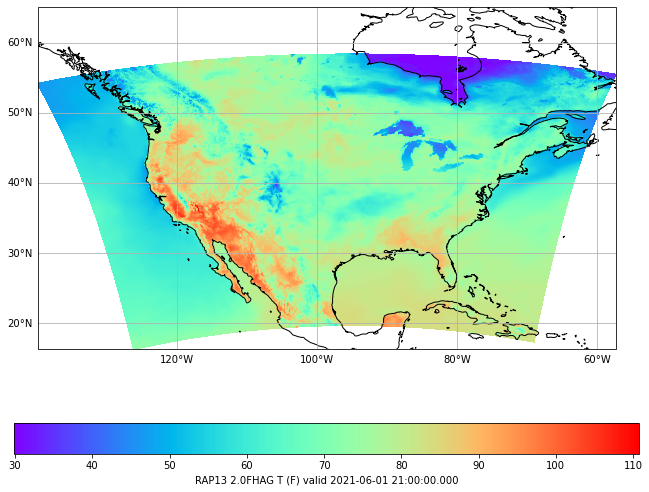

In [8]:
cmap = plt.get_cmap('rainbow')
fig, ax = make_map(bbox=bbox)
cs = ax.pcolormesh(lons, lats, data, cmap=cmap)
cbar = fig.colorbar(cs, shrink=0.7, orientation='horizontal')
cbar.set_label(grid.getLocationName() +" "+ grid.getLevel() + " " \
               + grid.getParameter() + " (" + destUnit + ") " \
               + "valid " + str(grid.getDataTime().getRefTime()))

### Plot Using contourf

This example shows how to use [matplotlib.pyplot.contourf](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.contourf.html) to create a colorized plot. We use our **make_map** function to create a subplot and then we create a color scale (cs2) and colorbar (cbar2) with a label for our plot.

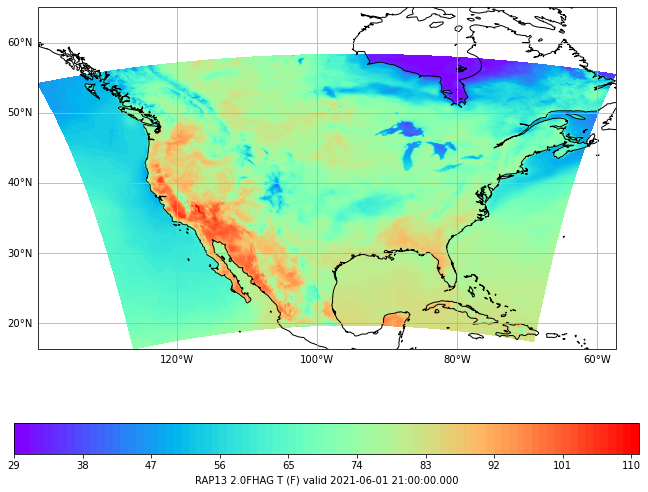

In [9]:
fig2, ax2 = make_map(bbox=bbox)
cs2 = ax2.contourf(lons, lats, data, 80, cmap=cmap,
                  vmin=data.min(), vmax=data.max())
cbar2 = fig2.colorbar(cs2, shrink=0.7, orientation='horizontal')
cbar2.set_label(grid.getLocationName() +" "+ grid.getLevel() + " " \
               + grid.getParameter() + " (" + destUnit + ") " \
               + "valid " + str(grid.getDataTime().getRefTime()))

<a href="#top">Top</a>

---

## See Also

### Related Notebooks

* [Grid Levels and Parameters](https://unidata.github.io/python-awips/examples/generated/Grid_Levels_and_Parameters.html)

### Additional Documentation

**python-awips:**
* [awips.DataAccessLayer](http://unidata.github.io/python-awips/api/DataAccessLayer.html)
* [awips.PyGridData](http://unidata.github.io/python-awips/api/PyGridData.html)

**matplotlib:**
* [matplotlib.pyplot](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.html)
* [matplotlib.pyplot.subplot](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.subplot.html)
* [matplotlib.pyplot.pcolormesh](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.pcolormesh.html)
* [matplotlib.pyplot.contourf](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.contourf.html)

<a href="#top">Top</a>

---